# Access to the resource content

Vortex initialisation:

In [1]:
%load_ext ivortex
%vortex tmpcocoon

# [2019/09/03-11:05:30][vortex.sessions][_set_rundir:0152][WARNING]: Session <root> is changing its working directory </sauvegarde/vortex-dev/vortex/examples/notebooks/tutorial>
# [2019/09/03-11:05:30][vortex.sessions][_set_rundir:0155][INFO]: Session <root> set rundir </home/meunierlf/vortex-workdir/auto_cocoon_wbghb2v6>


Vortex 1.6.2 loaded ( Tuesday 03. September 2019, at 11:05:29 )
The working directory is now: /home/meunierlf/vortex-workdir/auto_cocoon_wbghb2v6/root


'/home/meunierlf/vortex-workdir/auto_cocoon_wbghb2v6'

## Principle

The resource's *Handler* contains all the necessary information for the retrieval of the data (*Resource* and *Provider*) but also the location of these data locally (via the *Container*). So it seems natural that the resource's *Handler* is able to instantiate an object allowing data manipulation (read, modify and write) based on the characteristics of the *Resource* and *Container* objects.

In practice, the creation of such an object (which we will later call  *Content*) occurs during the first call to the **contents** property of the resource's *Handler*. When the object is created, the data is loaded (at least partially) into memory, which can have a certain cost. If you wish to free this memory, you can call the **reset_contents** method of the resource's *Handler* which will destroy the *Content* object.

These objects all inherit from the **vortex.data.contents.DataContent** class and are specialised to handle one or another type of data. 

*Note*: Such objects only exist for a limited number of resources and formats. 

## Manipulation of simple data

Here we will take the example of data stored in JSON format.

In [2]:
rhpearo = toolbox.input(role='Clustering', now=True, verbose=False,
                        # Resource
                        kind='mbsample', nbsample='12', model='arome', date='2017082921',
                        cutoff='production',
                        # Provider
                        vapp='arome', vconf='pefrance', experiment='OPER',
                        namespace='vortex.archive.fr', block='clustering',
                        # Container
                        shouldfly=True, format='json')

# [2019/09/03-11:12:06][vortex.data.stores][inarchiveget:1199][INFO]: inarchiveget on vortex://vsop.archive.fr//home/m/mxpt/mxpt001/vortex/arome/pefrance/OPER/2017/08/29/T2100P/clustering/mbsampleof12.json (to: /home/meunierlf/vortex-workdir/auto_cocoon_wbghb2v6/root/shouldfly-v5igudgz)
# [2019/09/03-11:12:06][vortex.tools.storage][_ftpretrieve:0690][INFO]: ftpget on ftp://hendrix.meteo.fr//home/m/mxpt/mxpt001/vortex/arome/pefrance/OPER/2017/08/29/T2100P/clustering/mbsampleof12.json (to: /home/meunierlf/vortex-workdir/auto_cocoon_wbghb2v6/root/shouldfly-v5igudgz)
# [2019/09/03-11:12:06][vortex.tools.net][get:0268][INFO]: FTP <get:/home/m/mxpt/mxpt001/vortex/arome/pefrance/OPER/2017/08/29/T2100P/clustering/mbsampleof12.json>


It is a file produced at the beginning of the Arome ensemble prediction system that contains the list of global EPS members that will be used to provide lateral boundary conditions for each of the 12 members of Arome-EPS.

### Retrieving the *Content* object and inspecting the data

In [3]:
ctpearo = rhpearo[0].contents
ctpearo

Any *Content* object (derived from **vortex.data.contents.DataContent**) has a **data** _property_ that provides direct access to (raw) data:

In [4]:
import pprint
pprint.pprint(ctpearo.data, depth=1)

{'cutoff': 'production',
 'date': '201708292100',
 'drawing': [...],
 'population': [...],
 'resource_kind': 'mbsample',
 'vapp': 'arome',
 'vconf': 'pefrance'}


In this example, we are talking about the content of the JSON file that was read by the adhoc Python module and converted into “real” Python objects (lists, dictionaries ...).

Of course, the developer can provide additional methods that can be extremely specialised. For example, with this type of *Content* object (**common.data.eps.SampleContent**), one can ask for the list of global EPS members that were selected: 

In [5]:
ctpearo.members

[1, 5, 22, 18, 7, 9, 11, 12, 31, 17, 19, 34]

For a given type of *Content*, except the **data** _property_, which is standard, it is necessary to refer to the documentation of the various classes to know the methods offered by the developer.

### Editing data via the *Content* object

In [6]:
ctpearo.data['cutoff'] = 'assim'

In [7]:
import pprint
pprint.pprint(ctpearo.data, depth=1)

{'cutoff': 'assim',
 'date': '201708292100',
 'drawing': [...],
 'population': [...],
 'resource_kind': 'mbsample',
 'vapp': 'arome',
 'vconf': 'pefrance'}


Note that the JSON file has been altered (as expected), but the change has only occurred in the *Content* object itself: it has not been written in the *Container*. For that purpose, The *Content* object makes available the standard **rewrite** method for rewriting the content in a given *Container*.

Save our modified JSON in a file named ``foo.json``:

In [8]:
new_container = fp.proxy.container(filename='foo.json', format='json')
ctpearo.rewrite(new_container)
%ls

foo.json  shouldfly-v5igudgz


Most of the time, we do not want to create a copy but rather overwrite the original data. In this case the resource's *Handler* object offers a shortcut via the **save** method:

In [9]:
rhpearo[0].save()

**Note**: The **rewrite** method is not always implemented. Check in the code of the *Content* class. 

### Example of use 

In the case of our Arome EPS system, this *Content* is used to retrieve the necessary global EPS files in order to produce the lateral boundary condition files:

In [10]:
rhpearo = toolbox.input(role='Clustering', now=True, verbose=False, loglevel='warning',
                        # Resource
                        kind='mbsample', nbsample='12', model='arome', date='2017082921',
                        cutoff='production',
                        # Provider
                        vapp='arome', vconf='pefrance', experiment='OPER',
                        namespace='vortex.archive.fr', block='clustering',
                        # Container
                        shouldfly=True, format='json')

rhbis = toolbox.input(role='CouplingSource', now=False, verbose=False,
                      # Resource
                      kind='historic', model='arpege',  date='2017082918', 
                      cutoff='production', term=3, geometry='global798',
                      # Provider
                      vapp='arpege', vconf='pearp', experiment='OPER', block='forecast',
                      member=rhpearo[0].contents.members, namespace='vortex.archive.fr',
                      # Container
                      local='CPLIN_[member]+[term:fmthm]', format='fa')

In [11]:
print('I would get:')
print([rh.container.localpath() for rh in rhbis])

I would get:
['CPLIN_001+0003:00', 'CPLIN_005+0003:00', 'CPLIN_022+0003:00', 'CPLIN_018+0003:00', 'CPLIN_007+0003:00', 'CPLIN_009+0003:00', 'CPLIN_011+0003:00', 'CPLIN_012+0003:00', 'CPLIN_031+0003:00', 'CPLIN_017+0003:00', 'CPLIN_019+0003:00', 'CPLIN_034+0003:00']


## Another common example: the Fortran namelists

Let's retrieve an Arpège namelist via Uenv (in operations, the retrieval would be done via Genv): 

In [12]:
rhnam = toolbox.input(role='Namelist', now=True, verbose=False, loglevel='warning',
                      # Resource
                      kind='namelist', model='arpege', source='namelistfc',
                      # Provider
                      genv='uget:cy42_op2.01fake@ugetdemo',
                      # Container
                      local='fort.4')
%ls

cy42_op2.09lf.nam/     foo.json  shouldfly-v5igudgz
cy42_op2.09lf.nam.tgz  fort.4    shouldfly-vg64mn_w


Let's retrieve the associated *Content* object:

In [13]:
ctnam = rhnam[0].contents

The namelist file is seen as a dictionary of namelist blocks. We can display the contents of a given namelist block:

In [14]:
print(ctnam['NAMPAR0'].dumps())

 &NAMPAR0
   MBX_SIZE=2048000000,
   MP_TYPE=2,
   NOUTPUT=1,
   NPROC=__NBPROC__,
   NSPECRESMIN=1199,
 /



Note that the “NPROC” variable is not really defined. This is a “macro” for which a value must be provided by the user. These macros can take two forms: 

  * If they are predefined in the Vortex code: we can directly use the name of the macro (``NPROC = NBPROC``) 
  * To avoid having to predefine macro names in advance, just use the notation ``__MACRONAME__`` (this is now recommended because it avoids changing the Vortex code too often)

Moreover, it is possible to modify variables (the conversion between Python type and Fortran type is managed), to delete them, or to add new ones to the namelist block,... 

In [15]:
ctnam.setmacro('NBPROC', 10)
ctnam['NAMPAR0'].MP_TYPE = 'Toto'
ctnam['NAMPAR0'].NOUTPUT = 1.2586e-6
del ctnam['NAMPAR0'].NSPECRESMIN

In [16]:
print(ctnam['NAMPAR0'].dumps())

 &NAMPAR0
   MBX_SIZE=2048000000,
   MP_TYPE='Toto',
   NOUTPUT=1.2586D-06,
   NPROC=10,
 /



Do not forget that changes made via the *Content* object are stored in memory: you have to save the result in a *Container*... 

In [17]:
rhnam[0].save()

For more details see: http://intra.cnrm.meteo.fr/algopy/sphinx/vortex/current/technical/fortran.html

## Using external packages through *Content* **_FormatAdapter _**

For some formats (in the sense of the **actualfmt** attribute of the *Container*), it is possible to use external packages to access the data. For FA and GRIB formats, you can typically use the *epygram* package:

https://opensource.umr-cnrm.fr/projects/epygram 

The idea of the generic **FormatAdapter** *Content* is to query a *footprints* collector named “dataformat” to determine if an external package is able read the data ... 

In [18]:
import common.util.usepygram
print('\n'.join([str(f) for f in fp.proxy.dataformats.items()]))

# [2019/09/03-11:33:37][epygram][prompt:0105][WARNING]: *epygram* is now supposed to be compatible with Python3, provided you have an ecCodes >= 2.10.0 !
# [2019/09/03-11:33:38][common.util.usepygram][<module>:0037][INFO]: Epygram 1.3.7 loaded.


<class 'epygram.formats.LFA.LFA'>
<class 'epygram.formats.DDHLFA.DDHLFA'>
<class 'epygram.formats.netCDF.netCDF'>
<class 'epygram.formats.GeoPoints.GeoPoints'>
<class 'epygram.formats.LFI.LFI'>
<class 'epygram.formats.TIFFMF.TIFFMF'>
<class 'epygram.formats.netCDFMNH.netCDFMNH'>
<class 'vortex.tools.listings.ArpifsListingsFormatAdapter'>
<class 'epygram.formats.GRIB.GRIB'>
<class 'epygram.formats.FA.FA'>


### Demonstration

In [19]:
rhS = vortex.toolbox.input(role='Gridpoint', now=True, verbose=False,
                           # Container
                           local='epytest_[geometry:area]_[term]', format='grib',
                           # Resource
                           kind='gridpoint', geometry='antil0025', origin='historic',
                           date='2016100100', term='0', cutoff='production', model='[vapp]',
                           nativefmt='[format]',
                           # Provider
                           experiment='OPER', block='forecast', namespace='vortex.multi.fr',
                           vapp='arome', vconf='antilles')

# [2019/09/03-11:33:55][vortex.data.stores][incacheget:1767][INFO]: incacheget on vortex://vsop.cache-mt.fr//arome/antilles/OPER/20161001T0000P/forecast/grid.arome-forecast.antil0025+0000:00.grib (to: epytest_ANTIL0025_00:00)
# [2019/09/03-11:33:55][vortex.data.stores][incacheget:1781][INFO]: incacheget retrieve rc=True location=/home/meunierlf/cache/vortex/arome/antilles/OPER/20161001T0000P/forecast/grid.arome-forecast.antil0025+0000:00.grib


In [20]:
epy_fiels = rhS[0].contents.data
epy_fiels

Reading a GRIB field:

In [21]:
field = epy_fiels.readfield(dict(shortName='t', typeOfLevel='isobaricInhPa', level=850))
print(field.stats())

{'max': 293.958984375, 'std': 0.8545431029082723, 'min': 289.091796875, 'mean': 290.77099109730847, 'nonzero': 301875, 'quadmean': 290.7722467974304}


In [22]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore", module='.*basemap')  # A corriger côté Epygram

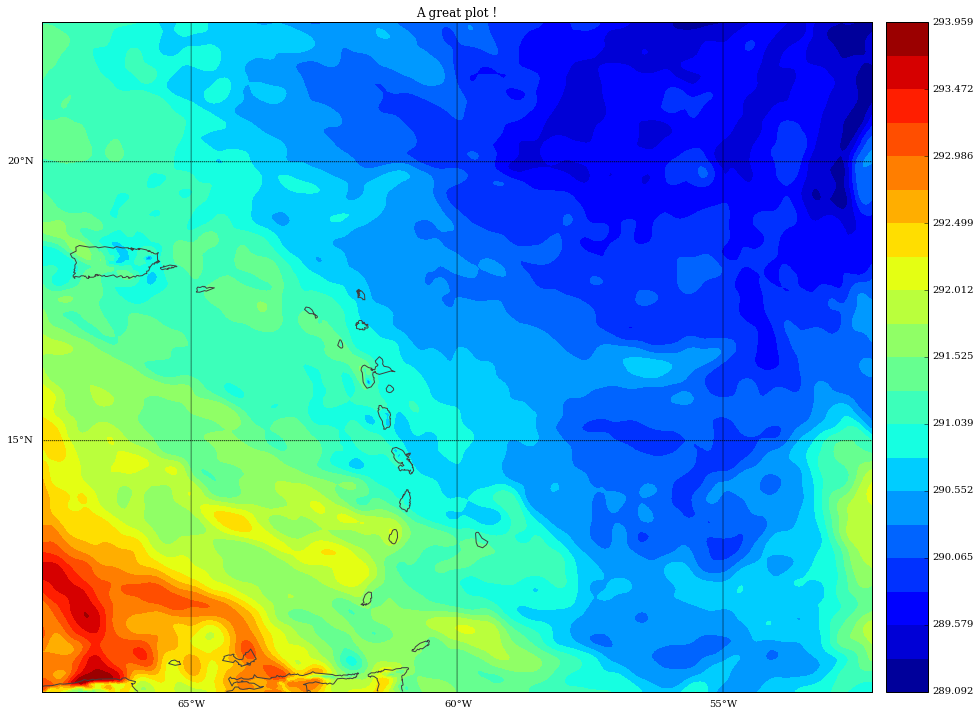

In [23]:
fig = field.plotfield(title="A great plot !")

### What's going on behind the scenes?

The **FormatAdapter** *Content* simply looks into the "``dataformat``" *footprints*' collector to create an object. If the creation of the object is successful, it is assigned to the **data** attribute of the *Content* object: 

In [24]:
access_obj = fp.proxy.dataformat(filename=rhS[0].container.abspath,
                                 openmode='r', fmtdelayedopen=True,
                                 format=rhS[0].container.actualfmt.upper())  # actualfmt='grib'
access_obj

Therefore, it is very easy to interface an external package with Vortex. It is enough to define an interface class: 

  * That is member of the *footprints*' collector "``dataformat``";
  * That satisfies the attributes mentioned above (*filename*, *openmode*, *fmtdelayedopen*, *format*).

## Development of new *Contents*

If you want to create a “Simple” *Content* (e.g. Arome-EPS JSON file), just: 

  * Create a class that inherits from **vortex.data.contents.DataContent** or any existing *Content* that is close to uour needs (for example, if the data is in JSON format, it may be wise to inherit from **vortex.data.contents.JsonDictContent**);
  * In the resource that is to benefit from this *Content*, assign the newly created *Content* class as a default value for the *footprints* attribute “``clscontent``”.

If you want to use an external package via the **FormatAdapter** *Content* (*e.g.* epygram):

  * Ensure that the external package provides an interface class that is registered with the "``dataformat``" *footprints*' collector. 
  * In the resource that should benefit from this *Content*, assign the **FormatAdapter** class as the default value for the *footprints* attribute "``clscontent``". 


# Modifying the content of resources when they are recovered

It is about the notion of *hook*: after the retrieval of a data (or before sending a data), the resource's *Handler* can call one or more utilitary functions, which will have access to the content of the Resource's *Handler*.

The functions in question must satisfy a strict interface:

  * The session ticket object is the first argument (the subject will be discussed later). 
  * The resource's *Handler* object on which the function applies is the second argument. 
    • (There may be other arguments that will be passed by the user during the call). 

Starting from our Fortran namelist example, we could imagine a utility function that updates the ``NOUTPUT`` variable of the ``NAMPAR0`` namelist: 

In [25]:
def fix_noutput(t, rh, noutput=1):
    # t: session ticket (the topic will be discussed later)
    # rh: the resource's handler to which this function should apply 
    # ... one or more arguments provided by the user
    rh.contents['NAMPAR0'].NOUTPUT = noutput
    rh.save()

Such a function can be used as "hook" when retrieving the namelist: 

In [26]:
rhnam = toolbox.input(role='Namelist', now=True, verbose=False, loglevel='warning',
                      hook_noutput = (fix_noutput, 5),  # Set NOUTPUT to 5
                      # Resource
                      kind='namelist', model='arpege', source='namelistfc',
                      # Provider
                      genv='uget:cy42_op2.01fake@ugetdemo',
                      # Container
                      local='namelbis')

Let's check the result:

In [27]:
print(rhnam[0].contents['NAMPAR0'].dumps())

 &NAMPAR0
   MBX_SIZE=2048000000,
   MP_TYPE=2,
   NOUTPUT=5,
   NPROC=__NBPROC__,
   NSPECRESMIN=1199,
 /



Some more information: 

  * Here, the utility function was created directly in the script. It is also possible to define the function inside the Vortex code and to refer to it by a string of characters. For example, we can use the following hook: "``common.util.usepygram.addfield``" (which is based on *epygram*).
  * This feature can be very convenient in R&D (to edit files on the fly) but be careful when using this feature in operations situation since it has a cost. In any case, for operational use, you must define the *hook* function in the Vortex code (not directly in the script). 
  * There may be several *hooks* (in this case, they will be executed in alphabetical order). 
  * In the case of hooks dealing with output data, each *hook* is executed only once on a per file basis (even if several calls to **toolbox.output** are made).

This mechanism offers great possibilities since one can use all the power of the *Contents* but more generally make any processing which requires to recover information in the resource's *Handler* (for example, in operational situation, the sending of the files to an external database is triggered via a hook on the output resource). 


Any questions: *vortex.support@meteo.fr*